In [69]:
import pandas as pd
import numpy as np
import pylab as plt
import scipy.optimize as op
from datetime import datetime

import os
from pandas.tseries.offsets import BDay

In [23]:
ret_file = os.path.join('MFE_DAM', 'Data', 'US.csv')
us_df = pd.read_csv(ret_file, parse_dates=[0], index_col=[0], na_values=[0])
us_df = us_df.fillna(method='ffill')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023D29CDBD30>,
      dtype=object)

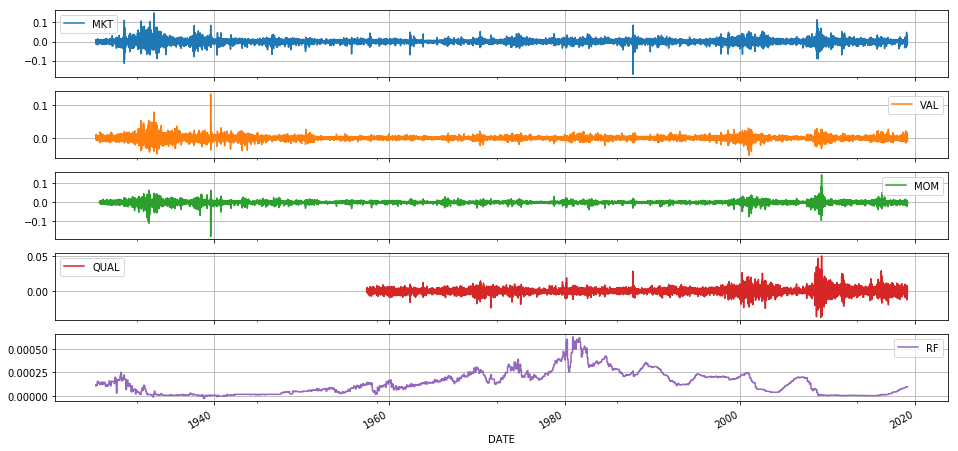

In [33]:
us_df.plot(figsize=(16,8), grid=True, subplots=True)

In [91]:
IR_year = os.path.join('MFE_DAM', 'US_IR_wrt_mkt_year.csv')
ir_mkt_year = pd.read_csv(IR_year, parse_dates=[0], index_col=[0], na_values=[0])
ir_mkt_year = ir_mkt_year.asfreq('Y', method='ffill').fillna(method='ffill')
ir_mkt_year[ir_mkt_year<0] = 0

In [92]:
ir_mkt_year.loc[ir_mkt_year.isnull().any(axis=1)]

,MOM,QUAL,RF,VAL
1926-12-31,NaN,NaN,0.710444,0.011591
1927-12-31,0.004052,NaN,0.458107,0.000000
1928-12-31,0.004426,NaN,0.193574,0.000000
1929-12-31,0.008219,NaN,0.397795,0.005514
1930-12-31,0.005484,NaN,0.140992,0.000000
1931-12-31,0.000129,NaN,0.117255,0.000000
1932-12-31,0.000000,NaN,0.056249,0.003681
1933-12-31,0.000000,NaN,0.051433,0.001279
1934-12-31,0.003061,NaN,0.075438,0.000000
1935-12-31,0.006527,NaN,0.179379,0.000000


In [73]:
day_lag = 1

In [75]:
weights = pd.DataFrame(columns = ir_mkt_year.columns, index = ir_mkt_year.index)
tmp_Sum = ir_mkt_year.sum(axis=1)
for col in weights.columns:
    weights[col] = ir_mkt_year[col]/tmp_Sum
weights.fillna(0, inplace=True)
weights.index = weights.index + BDay(day_lag)

In [139]:
weights

,MOM,QUAL,RF,VAL
1927-01-03,0.000000,0.000000,0.983946,0.016054
1928-01-02,0.008769,0.000000,0.991231,0.000000
1929-01-01,0.022353,0.000000,0.977647,0.000000
1930-01-01,0.019971,0.000000,0.966629,0.013400
1931-01-01,0.037439,0.000000,0.962561,0.000000
1932-01-01,0.001097,0.000000,0.998903,0.000000
1933-01-02,0.000000,0.000000,0.938581,0.061419
1934-01-01,0.000000,0.000000,0.975735,0.024265
1935-01-01,0.038994,0.000000,0.961006,0.000000
1936-01-01,0.035109,0.000000,0.964891,0.000000


In [77]:
weights_daily = pd.DataFrame(index=us_df.index)
for col in weights.columns:
    weights_daily[col] = weights[col]
weights_daily.fillna(method='ffill',inplace=True)

In [106]:
def cumul_perf(ret):
    """
    Function that converts a series of returns into the corresponding
    cumulative returns series

    Args:
        ret (pd.Series): series of returns

    Returns:
        cumulative returns series
    """
    return ((1 + ret).cumprod(axis=0)) - 1

In [136]:
us_df_ordered = us_df.reindex(columns=weights_daily.columns)
tmp_df = weights_daily*us_df_ordered.values
nonNanRow = min(np.where((~tmp_df.isnull()).any(axis=1))[0])
ret = tmp_df.sum(axis=1)
ret.iloc[:nonNanRow] = np.nan
perf = cumul_perf(ret)

perf_MKT = cumul_perf(us_df.loc[us_df.index[nonNanRow]:,'MKT'])

Text(0.5,1,'Pnl Comparison')

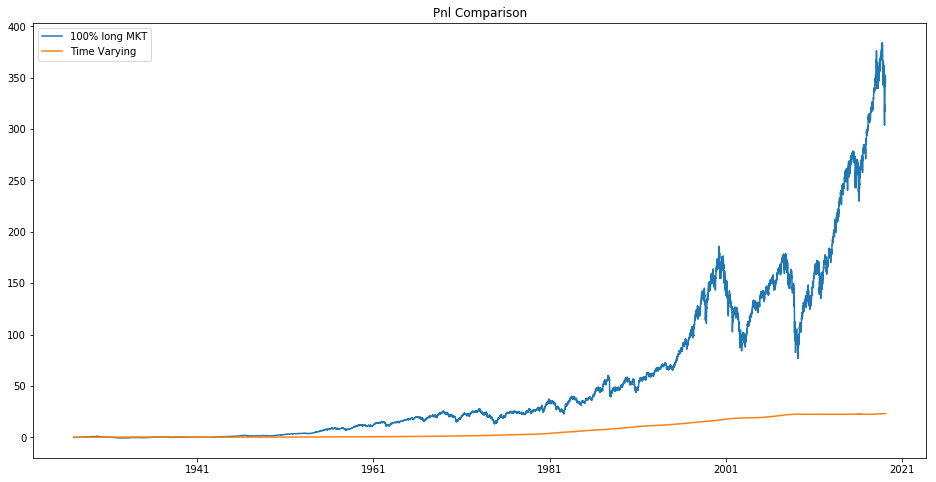

In [138]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
plt.plot(perf_MKT.index, perf_MKT.values, label='100% long MKT')
plt.plot(perf.index, perf.values, label='Time Varying')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')